# Scoring poses using RDKit feature maps

SuCOS allows to score individal pairs of molecules, but we want a method that determines how well a docked pose aligns to the fragment hits in general.

The hypothesis followed here is that it is the set of features, not the shape, that is critical. e.g. what's important is whether a pose forms a H-bond, not the exact shape of the molcule that provides the H-bond donor/acceptor.

Therefore we use the feature maps of the existing fragment hits to build a set of feature maps. Each map can be used individually to score a pose, but the key concept explored here is merging those feature maps into a single 'Frankenstein' feature map and using that to score poses. This approach should allow to score how well a pose corresponds to the set of interactions that we know are important for binding.

The core technology used is RDKit's feature map functionality, and most importantly the `CombineFeatMaps()` function.

In [69]:
import os, gzip, pickle

import pandas as pd
import numpy as np

from IPython.display import SVG
from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import PandasTools

from rdkit import Chem, rdBase, RDConfig
from rdkit.Chem import AllChem, rdShapeHelpers
from rdkit.Chem.FeatMaps import FeatMaps, FeatMapUtils
from rdkit.Chem.FeatMaps.FeatMapUtils import CombineFeatMaps

import plotly.express as px
import plotly.io as pio
import plotly.graph_objs as go

In [70]:
# Set the default renderer to png as the data is huge and overwhelms the Javascript renderers
pio.renderers.default = 'png'

In [71]:
# This is pretty well exact copy and paste from the SuCOS code in the Squonk Pipelines project:
# https://github.com/InformaticsMatters/pipelines/blob/master/src/python/pipelines/rdkit/sucos.py
# This code needs improving!!!

# Setting up the features to use in FeatureMap
ffact = AllChem.BuildFeatureFactory(os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef'))

fmParams = {}
for k in ffact.GetFeatureFamilies():
    fparams = FeatMaps.FeatMapParams()
    fmParams[k] = fparams

keep = ('Donor', 'Acceptor', 'NegIonizable', 'PosIonizable',
        'Aromatic', 'Hydrophobe', 'LumpedHydrophobe')

def filterFeature(f):
    result = f.GetFamily() in keep
    return result

def getRawFeatures(mol):
    rawFeats = ffact.GetFeaturesForMol(mol)
    # filter that list down to only include the ones we're interested in
    filtered = list(filter(filterFeature, rawFeats))
    return filtered

def getFeatureMap(mol):
    feats = getRawFeatures(mol)
    return FeatMaps.FeatMap(feats=feats, weights=[1]*len(feats),params=fmParams)

def gen_feats(mol):
    rawFeats = getRawFeatures(mol)
    return FeatMaps.FeatMap(feats=feats, weights=[1]*len(rawFeats), params=fmParams)

def get_FeatureMapScore(small_feats, large_feats, tani=False, score_mode=FeatMaps.FeatMapScoreMode.All):
    """
    Generate the feature map score.

    :param small_feats:
    :param large_feats:
    :param tani:
    :return:
    """

    featLists = []
    for rawFeats in [small_feats, large_feats]:
        # filter that list down to only include the ones we're interested in
        featLists.append(rawFeats)
    fms = [FeatMaps.FeatMap(feats=x, weights=[1] * len(x), params=fmParams) for x in featLists]
    # set the score mode
    fms[0].scoreMode = score_mode

    try:
        if tani:
            c = fms[0].ScoreFeats(featLists[1])
            A = fms[0].GetNumFeatures()
            B = len(featLists[1])
            if B != fms[1].GetNumFeatures():
                print("Why isn't B equal to number of features...?!")
            tani_score = float(c) / (A+B-c)
            return tani_score
        else:
            fm_score = fms[0].ScoreFeats(featLists[1]) / min(fms[0].GetNumFeatures(), len(featLists[1]))
            return fm_score
    except ZeroDivisionError:
        print("ZeroDivisionError")
        return 0

    if tani:
        tani_score = float(c) / (A+B-c)
        return tani_score
    else:
        fm_score = fms[0].ScoreFeats(featLists[1]) / min(fms[0].GetNumFeatures(), len(featLists[1]))
        return fm_score

def get_SucosScore(ref_mol, query_mol, tani=False, ref_features=None, query_features=None, score_mode=FeatMaps.FeatMapScoreMode.All):
    """
    This is the key function that calculates the SuCOS scores and is expected to be called from other modules.
    To improve performance you can pre-calculate the features and pass them in as optional parameters to avoid having
    to recalculate them. Use the getRawFeatures function to pre-calculate the features.

    :param ref_mol: The reference molecule to compare to
    :param query_mol: The molecule to compare to the reference
    :param tani: Whether to calculate Tanimoto distances
    :param ref_features: An optional feature map for the reference molecule, avoiding the need to re-calculate it.
    :param query_features: An optional feature map for the query molecule, avoiding the need to re-calculate it.
    :return: A tuple of 3 values. 1 the sucos score, 2 the feature map score,
        3 the Tanimoto distance or 1 minus the protrude distance
    """

    if not ref_features:
        ref_features = getRawFeatures(ref_mol)
    if not query_features:
        query_features = getRawFeatures(query_mol)

    fm_score = get_FeatureMapScore(ref_features, query_features, tani, score_mode)
    fm_score = np.clip(fm_score, 0, 1)

    try :
        if tani:
            tani_sim = 1 - float(rdShapeHelpers.ShapeTanimotoDist(ref_mol, query_mol))
            tani_sim = np.clip(tani_sim, 0, 1)
            SuCOS_score = 0.5*fm_score + 0.5*tani_sim
            return SuCOS_score, fm_score, tani_sim
        else:
            protrude_dist = rdShapeHelpers.ShapeProtrudeDist(ref_mol, query_mol, allowReordering=False)
            protrude_dist = np.clip(protrude_dist, 0, 1)
            protrude_val = 1.0 - protrude_dist
            SuCOS_score = 0.5 * fm_score + 0.5 * protrude_val
            return SuCOS_score, fm_score, protrude_val
    except:
        utils.log("Failed to calculate SuCOS scores. Returning 0,0,0")
        return 0, 0, 0

In [72]:
for k in ffact.GetFeatureFamilies():
    print(k)

Donor
Acceptor
NegIonizable
PosIonizable
ZnBinder
Aromatic
Hydrophobe
LumpedHydrophobe


In [73]:
# Read the 22 non-covalent hits
supplr = Chem.ForwardSDMolSupplier(gzip.open('../data/mpro/hits-23.sdf.gz'))
hits23 = [m for m in supplr]
len(hits23)

23

In [74]:
# Read all 69 hits (non-covalent and covalent)
supplr = Chem.ForwardSDMolSupplier(gzip.open('../data/mpro/hits-69.sdf.gz'))
hits69 = [m for m in supplr]
len(hits69)

69

In [75]:
# Some of the analyses below use the 'hits' variable rather that a specific set of hits.
# So define hits as whichever set we want.
hits = hits69

In [76]:
# Quick test that we can generate scores
mol0 = hits[0]
i = 0
for mol1 in hits:
    score = get_SucosScore(mol0, mol1)
    print('Scores for ', i, ' = ', score)
    i += 1

Scores for  0  =  (1.0, 1.0, 1.0)
Scores for  1  =  (0.2668961411329493, 0.19293647921783297, 0.3408558030480656)
Scores for  2  =  (0.04363207547169812, 0.0, 0.08726415094339623)
Scores for  3  =  (0.11590574374079526, 0.0, 0.23181148748159053)
Scores for  4  =  (0.1837065409546258, 0.0, 0.3674130819092516)
Scores for  5  =  (0.3252036371266338, 0.23831452403313258, 0.41209275022013503)
Scores for  6  =  (0.20058015743290825, 0.0016282879573637156, 0.3995320269084528)
Scores for  7  =  (0.5529834771417602, 0.39428704842885726, 0.7116799058546631)
Scores for  8  =  (0.3596023641744857, 0.049987541768630045, 0.6692171865803413)
Scores for  9  =  (0.006760728982951214, 0.0, 0.013521457965902428)
Scores for  10  =  (0.0, 0.0, 0.0)
Scores for  11  =  (0.2589972455468141, 0.16150079423053817, 0.35649369686308996)
Scores for  12  =  (0.0, 0.0, 0.0)
Scores for  13  =  (0.2877649278409524, 0.19195611414525476, 0.38357374153665)
Scores for  14  =  (0.04999999999999999, 0.0, 0.09999999999999998)

In [77]:
# let's compare the overlaps
i = 0
names = []
sucos_data = {}
feat_data = {}
for mol1 in hits:
    j = 0
    name = mol1.GetProp('_Name')[5:-2]
    names.append(name)
    sucos_scores = []
    feat_scores = []
    for mol2 in hits:
        scores = get_SucosScore(mol1, mol2)
        sucos_scores.append(scores[0])
        feat_scores.append(scores[1])
        j += 1
    i += 1
    sucos_data[name] = sucos_scores
    feat_data[name] = feat_scores
df_sucos = pd.DataFrame(sucos_data)
df_feats = pd.DataFrame(feat_data)
print(df_sucos.shape)
print(names)

(69, 69)
['x0072', 'x0104', 'x0107', 'x0161', 'x0195', 'x0305', 'x0354', 'x0387', 'x0395', 'x0397', 'x0426', 'x0434', 'x0540', 'x0678', 'x0689', 'x0691', 'x0692', 'x0705', 'x0708', 'x0731', 'x0734', 'x0736', 'x0749', 'x0752', 'x0755', 'x0759', 'x0769', 'x0770', 'x0771', 'x0774', 'x0786', 'x0820', 'x0830', 'x0831', 'x0874', 'x0946', 'x0967', 'x0978', 'x0981', 'x0991', 'x0995', 'x1077', 'x1093', 'x1249', 'x1308', 'x1311', 'x1334', 'x1336', 'x1348', 'x1351', 'x1358', 'x1374', 'x1375', 'x1380', 'x1382', 'x1384', 'x1385', 'x1386', 'x1392', 'x1402', 'x1412', 'x1418', 'x1425', 'x1458', 'x1478', 'x1493', 'x2052', 'x2097', 'x2193']


In [78]:
df_feats.shape

(69, 69)

In [79]:
df_sucos.head()

,x0072,x0104,x0107,x0161,x0195,x0305,x0354,x0387,x0395,x0397,...,x1402,x1412,x1418,x1425,x1458,x1478,x1493,x2052,x2097,x2193
0,1.000000,0.246989,0.054747,0.113565,0.165692,0.376398,0.154876,0.559726,0.349265,0.006635,...,0.049680,0.186057,0.399139,0.015188,0.128828,0.00641,0.090221,0.022357,0.028762,0.214015
1,0.266896,1.000000,0.039656,0.431046,0.472079,0.330220,0.100919,0.259781,0.290442,0.000000,...,0.000000,0.004852,0.225842,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.101449
2,0.043632,0.029412,1.000000,0.003432,0.018425,0.036360,0.009639,0.030431,0.063755,0.307829,...,0.000854,0.046643,0.086637,0.004440,0.004015,0.01533,0.001331,0.024292,0.035385,0.108113
3,0.115906,0.403990,0.004177,1.000000,0.590973,0.138884,0.076631,0.113664,0.117037,0.000000,...,0.000000,0.000000,0.093896,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.061052
4,0.183707,0.466748,0.027355,0.621461,1.000000,0.254278,0.137696,0.191203,0.190901,0.000000,...,0.000000,0.012939,0.159403,0.000000,0.000365,0.00000,0.000000,0.000103,0.000000,0.116433


In [80]:
df_sucos.head()

,x0072,x0104,x0107,x0161,x0195,x0305,x0354,x0387,x0395,x0397,...,x1402,x1412,x1418,x1425,x1458,x1478,x1493,x2052,x2097,x2193
0,1.000000,0.246989,0.054747,0.113565,0.165692,0.376398,0.154876,0.559726,0.349265,0.006635,...,0.049680,0.186057,0.399139,0.015188,0.128828,0.00641,0.090221,0.022357,0.028762,0.214015
1,0.266896,1.000000,0.039656,0.431046,0.472079,0.330220,0.100919,0.259781,0.290442,0.000000,...,0.000000,0.004852,0.225842,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.101449
2,0.043632,0.029412,1.000000,0.003432,0.018425,0.036360,0.009639,0.030431,0.063755,0.307829,...,0.000854,0.046643,0.086637,0.004440,0.004015,0.01533,0.001331,0.024292,0.035385,0.108113
3,0.115906,0.403990,0.004177,1.000000,0.590973,0.138884,0.076631,0.113664,0.117037,0.000000,...,0.000000,0.000000,0.093896,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.061052
4,0.183707,0.466748,0.027355,0.621461,1.000000,0.254278,0.137696,0.191203,0.190901,0.000000,...,0.000000,0.012939,0.159403,0.000000,0.000365,0.00000,0.000000,0.000103,0.000000,0.116433


In [81]:
df_sucos.to_csv('sucos-compare.csv', index=False)

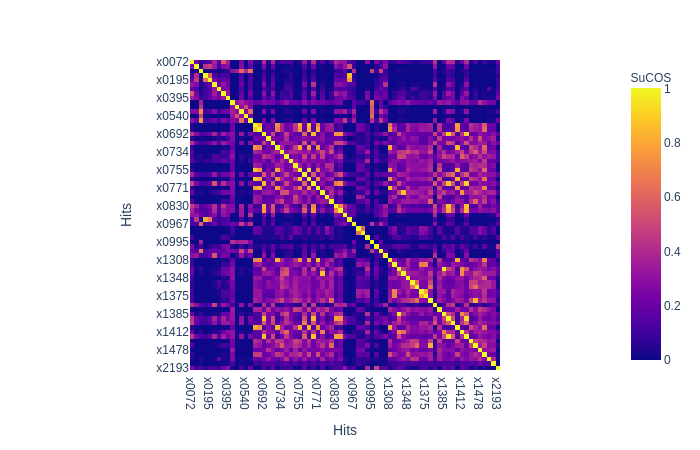

In [82]:
# So how does this look? First the SuCOS score
fig = px.imshow(df_sucos, labels=dict(x="Hits", y="Hits", color="SuCOS"), x=names, y=names)
fig.show()
# As expexcted some hits overlap to a differing degree

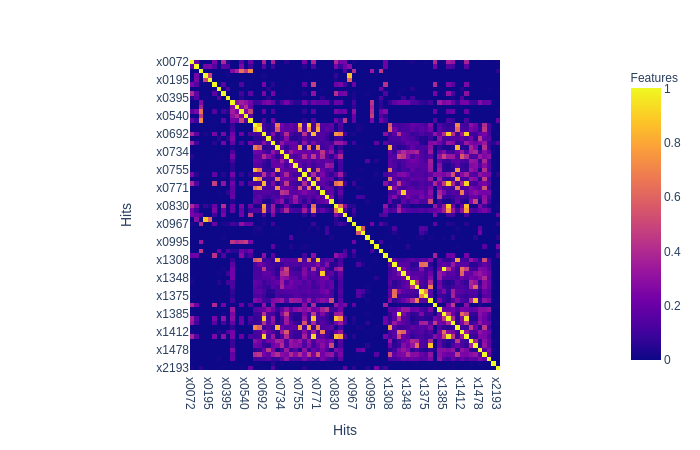

In [83]:
# Now just the features
fig = px.imshow(df_feats, labels=dict(x="Hits", y="Hits", color="Features"), x=names, y=names)
fig.show()

In [84]:
for hit in hits:
    featmap = getFeatureMap(hit)
    print(hit.GetProp('_Name'))
    print(featmap)

Mpro-x0072_0
  1        Donor  8.0610 -3.5350  24.6620  1.0000
  2     Acceptor  9.0830 -5.4410  26.1700  1.0000
  3     Acceptor  8.6390 -3.5100  27.2010  1.0000
  4     Aromatic  11.8907 -0.6435  23.4342  1.0000
  5   Hydrophobe  10.6040 -1.1420  23.3930  1.0000
  6   Hydrophobe  9.2100 -1.7480  23.3470  1.0000
  7 LumpedHydrophobe  11.8907 -0.6435  23.4342  1.0000

Mpro-x0104_0
  1        Donor  11.4270  5.4110  22.6760  1.0000
  2        Donor  10.3530  1.5710  24.3790  1.0000
  3     Acceptor  10.3130  6.1380  24.5460  1.0000
  4     Acceptor  13.6800 -1.7440  21.5180  1.0000
  5     Aromatic  11.3074  1.7342  23.7724  1.0000
  6     Aromatic  11.9252 -0.2008  22.9902  1.0000
  7   Hydrophobe  12.0650  2.5700  23.4230  1.0000
  8   Hydrophobe  12.1310  1.1860  23.1210  1.0000
  9   Hydrophobe  13.0500  3.6550  22.9570  1.0000
 10 LumpedHydrophobe  11.9252 -0.2008  22.9902  1.0000

Mpro-x0107_0
  1        Donor  7.8860 -0.6570  21.1000  1.0000
  2     Acceptor  9.4550  1.0030  20.9

# Combining and merging feature maps

In [133]:
# combining 2 feature maps (no merge)
feat0 = getFeatureMap(hits[0])
feat1 = getFeatureMap(hits[1])
merged = CombineFeatMaps(feat0, feat1)
print(feat0)
print(feat1)
print(merged)
# 7 + 10 = 17
# feature maps combined but not merged

  1        Donor  8.0610 -3.5350  24.6620  1.0000
  2     Acceptor  9.0830 -5.4410  26.1700  1.0000
  3     Acceptor  8.6390 -3.5100  27.2010  1.0000
  4     Aromatic  11.8907 -0.6435  23.4342  1.0000
  5   Hydrophobe  10.6040 -1.1420  23.3930  1.0000
  6   Hydrophobe  9.2100 -1.7480  23.3470  1.0000
  7 LumpedHydrophobe  11.8907 -0.6435  23.4342  1.0000

  1        Donor  11.4270  5.4110  22.6760  1.0000
  2        Donor  10.3530  1.5710  24.3790  1.0000
  3     Acceptor  10.3130  6.1380  24.5460  1.0000
  4     Acceptor  13.6800 -1.7440  21.5180  1.0000
  5     Aromatic  11.3074  1.7342  23.7724  1.0000
  6     Aromatic  11.9252 -0.2008  22.9902  1.0000
  7   Hydrophobe  12.0650  2.5700  23.4230  1.0000
  8   Hydrophobe  12.1310  1.1860  23.1210  1.0000
  9   Hydrophobe  13.0500  3.6550  22.9570  1.0000
 10 LumpedHydrophobe  11.9252 -0.2008  22.9902  1.0000

  1        Donor  8.0610 -3.5350  24.6620  1.0000
  2     Acceptor  9.0830 -5.4410  26.1700  1.0000
  3     Acceptor  8.6390 -3

In [138]:
# combining 2 feature maps (with merge)
feat0 = getFeatureMap(hits[0])
feat1 = getFeatureMap(hits[1])
merged = CombineFeatMaps(feat0, feat1, mergeMetric=1, mergeTol=1.5, dirMergeMode=1)
print(feat0)
print(feat1)
print(merged)
# we get 2 less features. Something is being merged!

  1        Donor  8.0610 -3.5350  24.6620  1.0000
  2     Acceptor  9.0830 -5.4410  26.1700  1.0000
  3     Acceptor  8.6390 -3.5100  27.2010  1.0000
  4     Aromatic  11.8907 -0.6435  23.4342  1.0000
  5   Hydrophobe  10.6040 -1.1420  23.3930  1.0000
  6   Hydrophobe  9.2100 -1.7480  23.3470  1.0000
  7 LumpedHydrophobe  11.8907 -0.6435  23.4342  1.0000

  1        Donor  11.4270  5.4110  22.6760  1.0000
  2        Donor  10.3530  1.5710  24.3790  1.0000
  3     Acceptor  10.3130  6.1380  24.5460  1.0000
  4     Acceptor  13.6800 -1.7440  21.5180  1.0000
  5     Aromatic  11.3074  1.7342  23.7724  1.0000
  6     Aromatic  11.9252 -0.2008  22.9902  1.0000
  7   Hydrophobe  12.0650  2.5700  23.4230  1.0000
  8   Hydrophobe  12.1310  1.1860  23.1210  1.0000
  9   Hydrophobe  13.0500  3.6550  22.9570  1.0000
 10 LumpedHydrophobe  11.9252 -0.2008  22.9902  1.0000

  1        Donor  8.0610 -3.5350  24.6620  1.0000
  2     Acceptor  9.0830 -5.4410  26.1700  1.0000
  3     Acceptor  8.6390 -3

In [87]:
# simplistic merging - merge in the order the molecules are in the file
featMaps = []
total_feature_count = 0
for mol in hits:
    featMap = getFeatureMap(mol)
    print('Processing mol', mol.GetProp('_Name'), 'found', featMap.GetNumFeatures())
    total_feature_count += featMap.GetNumFeatures()
    featMaps.append(featMap)
print('Generated', total_feature_count, 'features')

merged_f = None
for featMap in featMaps:
    #print(featMap)
    if not merged_f:
        merged_f = featMap
    else:
        merged_f = CombineFeatMaps(merged_f, featMap,  mergeMetric=1, mergeTol=1.5, dirMergeMode=1)
        
print(merged_f)

# 156 features are merged down to 88 (in the case of the 22 hits).
# 496 features are merged down to 175 (in the case of the 69 hits).

Processing mol Mpro-x0072_0 found 7
Processing mol Mpro-x0104_0 found 10
Processing mol Mpro-x0107_0 found 5
Processing mol Mpro-x0161_0 found 9
Processing mol Mpro-x0195_0 found 7
Processing mol Mpro-x0305_0 found 4
Processing mol Mpro-x0354_0 found 8
Processing mol Mpro-x0387_0 found 7
Processing mol Mpro-x0395_0 found 6
Processing mol Mpro-x0397_0 found 5
Processing mol Mpro-x0426_0 found 10
Processing mol Mpro-x0434_0 found 7
Processing mol Mpro-x0540_0 found 7
Processing mol Mpro-x0678_0 found 7
Processing mol Mpro-x0689_0 found 7
Processing mol Mpro-x0691_0 found 8
Processing mol Mpro-x0692_0 found 8
Processing mol Mpro-x0705_0 found 8
Processing mol Mpro-x0708_0 found 10
Processing mol Mpro-x0731_0 found 8
Processing mol Mpro-x0734_0 found 5
Processing mol Mpro-x0736_0 found 5
Processing mol Mpro-x0749_0 found 8
Processing mol Mpro-x0752_0 found 7
Processing mol Mpro-x0755_0 found 9
Processing mol Mpro-x0759_0 found 7
Processing mol Mpro-x0769_0 found 8
Processing mol Mpro-x0770

In [88]:
# see what happens if we reverse the order of the mols
featMaps = []
total_feature_count = 0
for mol in reversed(hits):
    featMap = getFeatureMap(mol)
    print('Processing mol', mol.GetProp('_Name'), 'found', featMap.GetNumFeatures())
    total_feature_count += featMap.GetNumFeatures()
    featMaps.append(featMap)
print('Generated', total_feature_count, 'features')

merged_r = None
for featMap in featMaps:
    #print(featMap)
    if not merged_r:
        merged_r = featMap
    else:
        merged_r = CombineFeatMaps(merged_r, featMap,  mergeMetric=1, mergeTol=1.5, dirMergeMode=1)
        
print(merged_r)

# The 23 hits give the same number of features, but the data is slightly different..
# The 69 hits give one more feature.
# So how we merge is important.

Processing mol Mpro-x2193_0 found 7
Processing mol Mpro-x2097_0 found 4
Processing mol Mpro-x2052_0 found 8
Processing mol Mpro-x1493_0 found 4
Processing mol Mpro-x1478_0 found 4
Processing mol Mpro-x1458_0 found 6
Processing mol Mpro-x1425_0 found 5
Processing mol Mpro-x1418_0 found 7
Processing mol Mpro-x1412_0 found 7
Processing mol Mpro-x1402_0 found 8
Processing mol Mpro-x1392_0 found 10
Processing mol Mpro-x1386_0 found 7
Processing mol Mpro-x1385_0 found 8
Processing mol Mpro-x1384_0 found 5
Processing mol Mpro-x1382_0 found 6
Processing mol Mpro-x1380_0 found 5
Processing mol Mpro-x1375_0 found 6
Processing mol Mpro-x1374_0 found 6
Processing mol Mpro-x1358_0 found 9
Processing mol Mpro-x1351_0 found 7
Processing mol Mpro-x1348_0 found 8
Processing mol Mpro-x1336_0 found 9
Processing mol Mpro-x1334_0 found 8
Processing mol Mpro-x1311_0 found 5
Processing mol Mpro-x1308_0 found 8
Processing mol Mpro-x1249_0 found 8
Processing mol Mpro-x1093_0 found 12
Processing mol Mpro-x1077_

In [89]:
# simplistic combining - no merge
combined_fmap = None
for featMap in featMaps:
    #print(featMap)
    if not combined_fmap:
        combined_fmap = featMap
    else:
        combined_fmap = CombineFeatMaps(combined_fmap, featMap)
        
print(combined_fmap)

# 156 features (22)
# 496 features (69)

  1        Donor  8.9090 -6.3070  25.8190  1.0000
  2     Acceptor  10.2200  1.7360  21.2410  1.0000
  3     Acceptor  8.3730  2.3720  22.7390  1.0000
  4 PosIonizable  8.9090 -6.3070  25.8190  1.0000
  5     Aromatic  9.5308 -1.1090  23.7497  1.0000
  6   Hydrophobe  9.6650  0.1670  23.2400  1.0000
  7 LumpedHydrophobe  9.5308 -1.1090  23.7497  1.0000
  8        Donor  6.0990 -5.0950  19.7620  1.0000
  9     Acceptor  5.3660 -3.3380  21.7620  1.0000
 10     Acceptor  7.5670 -2.4460  21.6170  1.0000
 11     Aromatic  6.3547 -2.5217  22.2598  1.0000
 12        Donor  7.0280 -3.2710  21.4800  1.0000
 13        Donor  6.6700 -0.8400  26.1410  1.0000
 14     Acceptor  4.6880 -1.3320  25.1460  1.0000
 15     Acceptor  5.9330 -4.6040  20.0290  1.0000
 16     Acceptor  6.4490  2.0480  28.4090  1.0000
 17     Acceptor  5.5020  2.2020  30.5310  1.0000
 18     Aromatic  5.9488  0.7482  28.3245  1.0000
 19   Hydrophobe  6.6950 -2.1500  24.1370  1.0000
 20        Donor  6.1620 -5.1120  24.2830  1.

## Hierarchical merging

The order is important, so let's merge is a smarter way. We'll take an approach similar to multiple sequence alignment where you align the most similar sequences in a recursive manner.

Iteratively merge the features
- Score all features vs. all features
- Find the 2 most similar
- Merge them
- Remove the 2 that were merged and replace with the merged one
- Update the scores to include the scores of the merged feature with the other features
- Repeat until there is only one feature map remaining

In [90]:
def score_featmaps(fm1, fm2):
    "Generate the score for 2 feature maps"
    return get_featmap_scores(fm1, fm2)[1]

def get_featmap_scores(fm1, fm2):
    "Generate the raw score and the normalised score"
    feat_score = fm1.ScoreFeats(fm2.GetFeatures())
    return feat_score, feat_score / fm1.GetNumFeatures()
    
def build_feat_data(mols):
    "Build the feature maps and do the all vs. all comparison"
    fmaps = []
    scores = []
    for mol1 in mols:
        fm1 = getFeatureMap(mol1)
        fmaps.append(fm1)
        row = []
        for mol2 in mols:
            fm2 = getFeatureMap(mol2)
            score = score_featmaps(fm1, fm2)
            row.append(score)
            #print(len(data), len(row), score)
        scores.append(row)
    return fmaps, scores

def find_closest(scores):
    #print('Find closest for', len(scores), len(scores[0]))
    best_score = 0
    for i in range(len(scores)):
        for j in range(len(scores)):
            if i == j:
                continue
            score = scores[i][j]
            if score > best_score:
                best_score = score
                best_row = i
                best_col = j
    return best_score, best_row, best_col

def merge_feat_maps(fmaps, scores):
    "Merge the 2 closest feature maps, remove them form the data and replace with the merged feature map"
    best_score, best_row, best_col = find_closest(scores)
    #print(best_score, best_row, best_col)
    feat1 = fmaps[best_row]
    feat2 = fmaps[best_col]
    print('Merging', best_row, 'and', best_col, 'with score', best_score, '#features:', feat1.GetNumFeatures(), feat2.GetNumFeatures())
    merged = CombineFeatMaps(feat1, feat2, mergeMetric=1, mergeTol=1.5, dirMergeMode=0)
    # need to make sure we delete the biggest index first to avoid changing the smaller index 
    if best_row > best_col:
        a = best_row
        b = best_col
    else:
        a = best_col
        b = best_row
        
    #print('Initial:', len(fmaps), len(scores), ','.join([str(len(x)) for x in scores]))
    del fmaps[a]
    del fmaps[b]
    del scores[a]
    del scores[b]
    for row in scores:
        del row[a]
        del row[b]
        
    #print('Intermediate:', len(fmaps), len(scores), ','.join([str(len(x)) for x in scores]))
    
    merged_scores = []
    for i in range(len(fmaps)):
        fmap = fmaps[i]
        score1 = score_featmaps(fmap, merged)
        score2 = score_featmaps(merged, fmap)
        scores[i].append(score1)
        merged_scores.append(score2)
        
    fmaps.append(merged)
    merged_scores.append(score_featmaps(merged, merged))
    scores.append(merged_scores)
    
    #print('Final:', len(fmaps), len(scores), ','.join([str(len(x)) for x in scores]))

In [91]:
# run the merging - first the 23 hits

fmaps23, scores23 = build_feat_data(hits23)
merged_fmaps23 = fmaps23.copy()
#print(len(fmaps22))
while len(merged_fmaps23) > 1:
    merge_feat_maps(merged_fmaps23, scores23)
merged_fmap_23 = merged_fmaps23[0]
fname = "featurestein-23.p"
pickle.dump(merged_fmap_23, open(fname, "wb" ))
print('Wrote merged feature map with', merged_fmap_23.GetNumFeatures(), 'features as pickle to', fname)

Merging 15 and 3 with score 0.8923258636920277 #features: 7 9
Merging 2 and 12 with score 0.6812557890268437 #features: 5 7
Merging 2 and 19 with score 0.6086204594190924 #features: 7 9
Merging 8 and 18 with score 0.5467078392431313 #features: 7 8
Merging 12 and 8 with score 0.46961296312303324 #features: 4 7
Merging 8 and 16 with score 0.4660499851430776 #features: 8 10
Merging 2 and 12 with score 0.4259491340405144 #features: 4 8
Merging 0 and 14 with score 0.39584735588967107 #features: 7 13
Merging 2 and 14 with score 0.3494880690393135 #features: 7 17
Merging 3 and 11 with score 0.3368308638309464 #features: 5 9
Merging 8 and 11 with score 0.28409542058583326 #features: 9 21
Merging 4 and 11 with score 0.31745973461006766 #features: 12 26
Merging 8 and 10 with score 0.2706394659009569 #features: 10 32
Merging 3 and 8 with score 0.2501922279038919 #features: 10 12
Merging 0 and 6 with score 0.21780434251930894 #features: 10 11
Merging 4 and 5 with score 0.19469481076312625 #feature

In [92]:
# and now merge the 69 hits

fmaps69, scores69 = build_feat_data(hits69)
merged_fmaps69 = fmaps69.copy()
#print(len(fmaps))
while len(merged_fmaps69) > 1:
    merge_feat_maps(merged_fmaps69, scores69)
merged_fmap_69 = merged_fmaps69[0]
fname = "featurestein-69.p"
pickle.dump(merged_fmap_69, open(fname, "wb" ))
print('Wrote merged feature map with', merged_fmap_69.GetNumFeatures(), 'features as pickle to', fname)

Merging 46 and 56 with score 0.9878593269909249 #features: 8 8
Merging 55 and 59 with score 0.9558948979278129 #features: 7 7
Merging 26 and 24 with score 0.9126079758604708 #features: 8 9
Merging 64 and 25 with score 0.9063320931551366 #features: 7 8
Merging 26 and 43 with score 0.8962269193217937 #features: 8 9
Merging 14 and 61 with score 0.8811484919385896 #features: 7 9
Merging 46 and 53 with score 0.8741025048013954 #features: 5 6
Merging 30 and 3 with score 0.8740904794981986 #features: 7 9
Merging 37 and 23 with score 0.8683128706979488 #features: 8 9
Merging 17 and 45 with score 0.8326960013282632 #features: 8 8
Merging 14 and 52 with score 0.8325790954872282 #features: 8 8
Merging 56 and 55 with score 0.7942880573067547 #features: 8 9
Merging 24 and 55 with score 0.7574405479109947 #features: 8 9
Merging 13 and 51 with score 0.7462364697109554 #features: 8 9
Merging 2 and 12 with score 0.7142338180115694 #features: 5 7
Merging 34 and 35 with score 0.7078068551294233 #features

In [93]:
# define which merged set we are going to use
fmaps = fmaps69
scores = scores69 
merged_fmap = merged_fmap_69
len(fmaps)

69

## Look at the 3D distribution of the merged features

In [94]:
def gen_feature_info(fmap):
    families = []
    x_pos = []
    y_pos = []
    z_pos = []
    weights = []
    for feat in fmap.GetFeatures():
        fam = feat.GetFamily()
        pos = feat.GetPos()
        weight = feat.weight
        families.append(fam)
        x_pos.append(pos.x)
        y_pos.append(pos.y)
        z_pos.append(pos.z)
        weights.append(weight)
    df_finfo = pd.DataFrame({'family':families, 'x':x_pos, 'y':y_pos, 'z':z_pos, 'weight':weights})
    return df_finfo

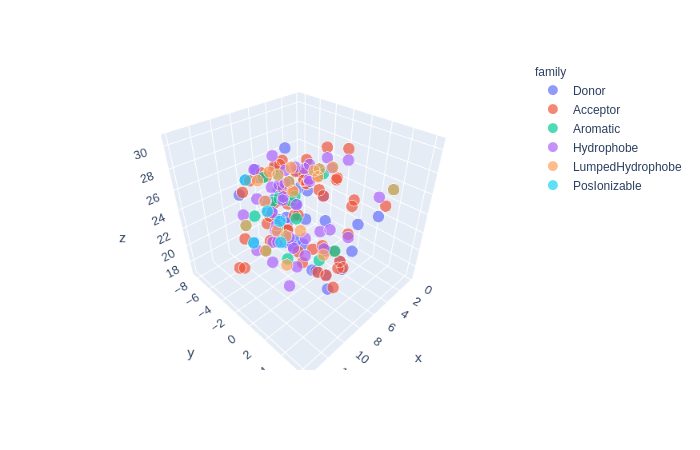

In [95]:
df_finfo_merged = gen_feature_info(merged_fmap)
fig = px.scatter_3d(df_finfo_merged, x='x', y='y', z='z', color='family', size='weight')
fig.show()

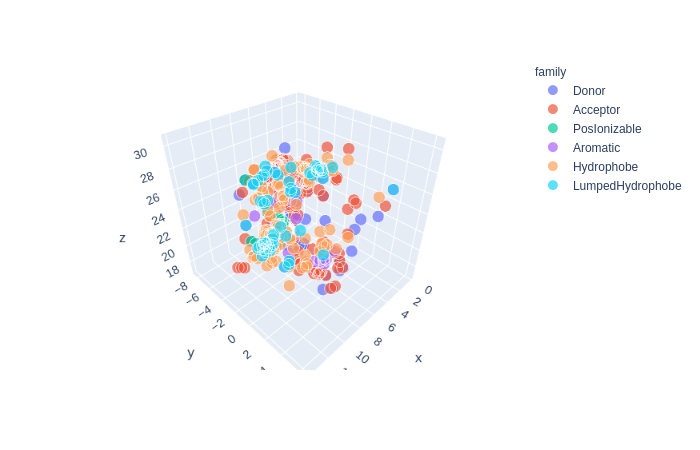

In [96]:
# compare with the combined maps (no merge)
df_finfo_combined = gen_feature_info(combined_fmap)
fig = px.scatter_3d(df_finfo_combined, x='x', y='y', z='z', color='family', size='weight')
fig.show()

In [97]:
# and for the combined maps
for featMap in fmaps:
    score = score_featmaps(featMap, combined_fmap)
    print(score)
# ahh! why not close to 1?

6.129613769296552
3.757044530516964
4.790696050486811
2.414043237058148
2.3875197047413645
4.910186455942574
1.5274265917870449
4.786896878421985
2.1065974178631937
9.633420513771203
2.238146313455064
6.345634106294381
3.031799136182222
5.601456997378618
10.524576784013506
9.826432013679188
12.049470425743618
5.523711661659295
7.850553869424786
9.182731879311262
10.27972452563269
11.470264306071329
7.071660009627352
6.950499181889486
9.069340165110212
10.23175909127384
10.581525247414927
12.505323991305797
9.513703035873064
9.005453241586487
7.4176806153619355
5.651759829545714
7.529279473015396
11.518436561140742
4.355260642429817
2.850107208788166
2.6571306072330243
2.274667752369541
1.9072656249231268
1.4681509573805158
3.6337305384581184
1.7670875755976017
2.1328935778625984
4.69158569051355
9.934388990287166
7.91558244073012
9.292330342537001
7.928398180908313
7.3019532455026415
7.488631195979579
6.615137413963017
8.223963419571023
6.827455115250316
11.091661085482784
6.0967550454

## Running predictions

In [98]:
# How about some candidates?
# These are a subset of Mpro-x0387 hit expanded and enumerate (charge states)
#   docked into Mpro-0387 using tethered docking. 
gz = gzip.open('../tethering/Mpro-x0387_into_x0387_default_tether.sdf.gz')
supplr = Chem.ForwardSDMolSupplier(gz)
tethered_poses = []
count = 0
for m in supplr:
    if count % 40 == 0:
        tethered_poses.append(m)
    count += 1
len(tethered_poses)

296

In [99]:
# Let's just score some molecules - first the original hits.
# We'd expect them to all score close to 1

for featMap in fmaps:
    score = score_featmaps(featMap, merged_fmap)
    print(score)
    
# they do. All score close to 1 so that's what we expect. 

0.8974206380453731
1.0098916568806104
1.0025113153062495
0.957682572699775
0.8658054602712262
0.7910747228711005
1.0227377052442934
0.8696309365511857
0.9651551160978237
0.8907391022726528
0.9326689230489386
0.8802761784506155
0.9860207334975144
0.9419171302294745
0.8465133323211639
0.9418637977774675
0.7980582647794205
0.9360366535011906
0.8776218830090705
0.9409179046400862
0.9888438342536094
0.8411584004562199
1.0585804946957016
1.0393771357402792
0.997493224047184
0.7837570378849964
0.9969754005140088
0.7355890166944337
0.9962270030745543
0.9085590641148625
1.000378045104768
1.0177591012658178
0.8275045333456571
0.7286048802287194
0.9810111349901061
0.9535835064337609
0.9024127283658809
0.9798691381572343
0.9639640927970106
1.1892461682305393
1.0408170378058057
0.8489245039921088
1.0063500255776716
0.8846793040046006
0.9449088566646459
0.8523122618612533
0.8855630650693079
0.8531779562393356
1.0285053902375776
0.9563492186008374
0.9904020314289554
0.9297023432348158
0.8835166052632

In [100]:
# function to generate the sucos score of a set of poses
def gen_sucos_scores(poses):
    i = 0
    data = {}
    x_names = []
    y_names = []

    for mol2 in poses:
        name = mol2.GetProp('_Name')
        y_names.append(name)

    for mol1 in hits:
        j = 0
        name = mol1.GetProp('_Name')
        x_names.append(name)
        scores = []
        for mol2 in poses:
            score = get_SucosScore(mol1, mol2)
            scores.append(score[0])
            mol2.SetDoubleProp('SuCOSScore', score[0])
            j += 1
        i += 1
        data[name] = scores
    dft = pd.DataFrame(data)
    print(dft.shape)
    print(len(x_names))
    print(len(y_names))

    return dft, x_names, y_names

In [101]:
# let's compare the individual overlaps
df_tethered, x_names_tethered, y_names_tethered = gen_sucos_scores(tethered_poses)

(296, 69)
69
296


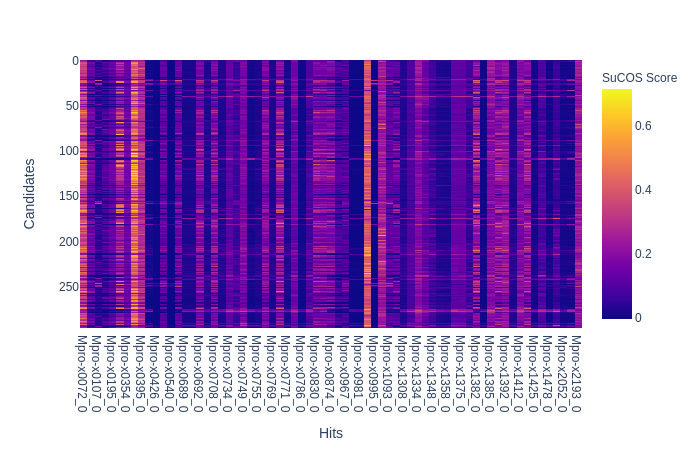

In [102]:
fig = px.imshow(df_tethered, labels=dict(x="Hits", y="Candidates", color="SuCOS Score"), x=x_names_tethered)
fig.show()

# Not surprisingly Mpro-x0387 scores best as that's what these ligands were tethered to when docked
# TODO - should we remove the originating hit from the comparison?

In [103]:
def gen_fmap_scores(poses, fmap):
    count = 0
    qual_scores = []
    quant_scores = []
    for mol in poses:
        name = mol.GetProp('_Name')
        featMap = getFeatureMap(mol)
        fmscores = get_featmap_scores(featMap, fmap)
        quant_scores.append(fmscores[0])
        qual_scores.append(fmscores[1])
        mol.SetDoubleProp('FeatureSteinQualScore', fmscores[1])
        mol.SetDoubleProp('FeatureSteinQuantScore', fmscores[0])
        #print(count, name, mol.GetProp('SCORE.norm'), score)
        count += 1
    return pd.DataFrame({'qual': qual_scores, 'quant': quant_scores})

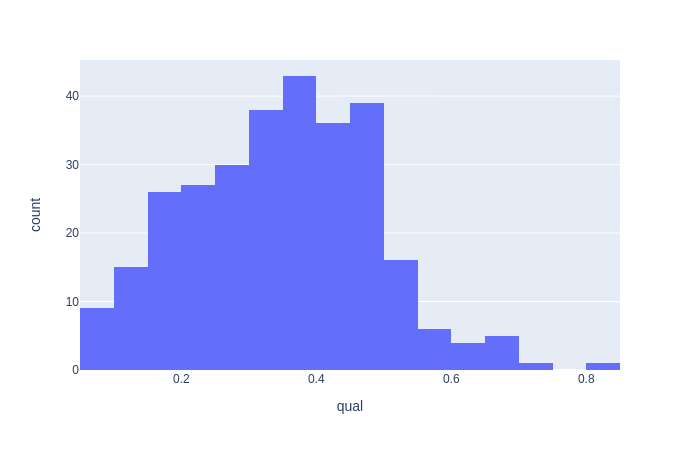

In [104]:
# look at the distribution of meged feature map scores
df3 = gen_fmap_scores(tethered_poses, merged_fmap)
fig = px.histogram(df3,  x='qual')
fig.show()
# We get a reasonable distribution of scores
# Are they usefull?

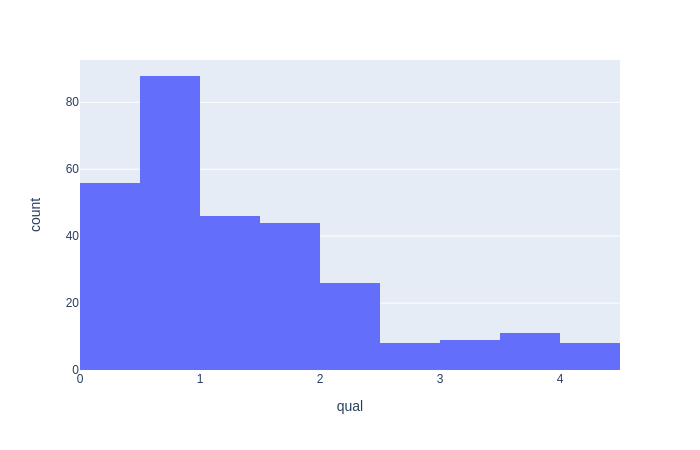

In [105]:
# And the combined feature map scores
df3 = gen_fmap_scores(tethered_poses, combined_fmap)
fig = px.histogram(df3,  x='qual')
fig.show()
# We get a reasonable distribution of scores
# Are they usefull?

In [106]:
# write the scored mols as SDF
def sort_by_fs_score(mol):
    return mol.GetDoubleProp('FeatureSteinQuantScore')

sorted_mols = sorted(tethered_poses, key=sort_by_fs_score, reverse=True)

w = Chem.SDWriter('../data/Tethered_FeaturesteinScore.sdf')
for mol in sorted_mols:
    w.write(mol)
w.close()

In [107]:
# look at untethered docking
gz = gzip.open('../tethering/Mpro-x0387_into_x0387_free.sdf.gz')
supplr = Chem.ForwardSDMolSupplier(gz)
free_poses = []
count = 0
for m in supplr:
    if count % 110 == 0:
        free_poses.append(m)
    count += 1
len(free_poses)

299

In [108]:
# let's compare the individual overlaps
df_free, x_names_free, y_names_free = gen_sucos_scores(free_poses)

(299, 69)
69
299


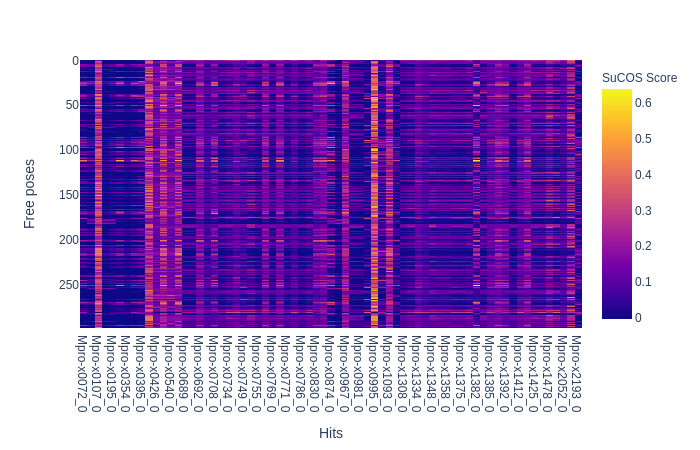

In [109]:
fig = px.imshow(df_free, labels=dict(x="Hits", y="Free poses", color="SuCOS Score"), x=x_names_free)
fig.show()

In [110]:
df_free_scores = gen_fmap_scores(free_poses, merged_fmap)
df_free_scores.shape

(299, 2)

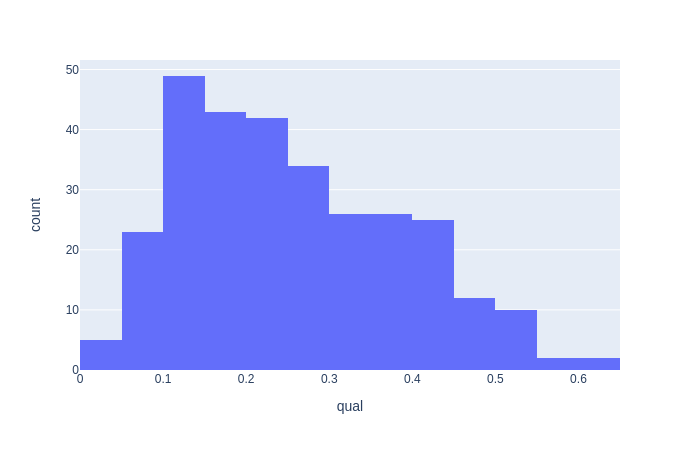

In [111]:
fig = px.histogram(df_free_scores,  x='qual')
fig.show()
# As we might expect, a lower distribution of scores when the docking isn't tethered

In [112]:
sorted_mols = sorted(free_poses, key=sort_by_fs_score, reverse=True)

w = Chem.SDWriter('../data/Free_FeaturesteinScore.sdf')
for mol in sorted_mols:
    w.write(mol)
w.close()

# MORE ANALYSIS NEEDED
.. but the basics seem in place

# Bigger molecules

One thing of concern is that these candidates are all not that much bigger than the hits from which they were expanded. So it may be hard for them to have much overlap with multiple fragment hits. So let's see whether you get better overalp with bigger molecules. We'll use John Chodera's poses of the Moonshot compoounds (https://github.com/FoldingAtHome/covid-moonshot/tree/master/moonshot-submissions).

In [113]:
# Read John Chodera's docked poses of moonshot compounds
gz = gzip.open('../data/misc/covid_submissions_all_info-docked-overlap.sdf.gz')
supplr = Chem.ForwardSDMolSupplier(gz)
chodera_poses = []
count = 0
for m in supplr:
    chodera_poses.append(m)
    count += 1
len(chodera_poses)

4635

In [114]:
df_chodera, chodera_x_names, chodera_y_names = gen_sucos_scores(chodera_poses)

(4635, 69)
69
4635


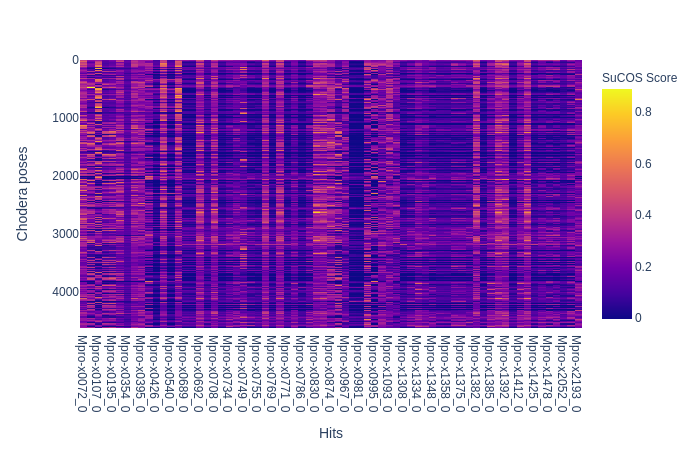

In [115]:
fig = px.imshow(df_chodera, labels=dict(x="Hits", y="Chodera poses", color="SuCOS Score"), x=chodera_x_names)
fig.show()
# reasonable overlap with most hits

In [116]:
df_fmapscores_chodera = gen_fmap_scores(chodera_poses, merged_fmap)
df_fmapscores_chodera.shape

(4635, 2)

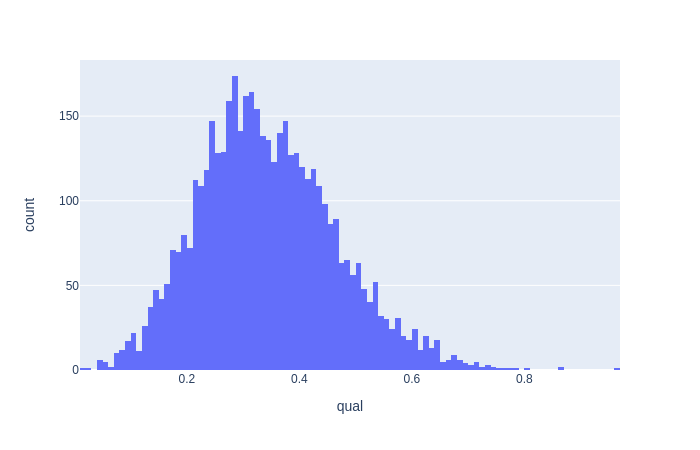

In [117]:
fig = px.histogram(df_fmapscores_chodera,  x='qual')
fig.show()
# Distribution marginally better than the fragment network hits with untethered docking?

In [118]:
chodera_sorted_mols = sorted(chodera_poses, key=sort_by_fs_score, reverse=True)

w = Chem.SDWriter('Chodera_FeaturesteinScore.sdf')
for mol in chodera_sorted_mols:
    w.write(mol)
w.close()

In [119]:
df_chodera = PandasTools.LoadSDF('Chodera_FeaturesteinScore.sdf', molColName='Molecule')
df_chodera.dtypes

creator                                                      object
fragments                                                    object
link                                                         object
real_space                                                   object
SCR                                                          object
                                                              ...  
Mpro-x1077_dock                                              object
Mpro-x0981_dock                                              object
Mpro-x0874,x1412_dock                                        object
Mpro-x0305,x1249_dock                                        object
Mpro-x0107,x0426,x0691,x0786,x0946,x0981,x1249,x1311_dock    object
Length: 406, dtype: object

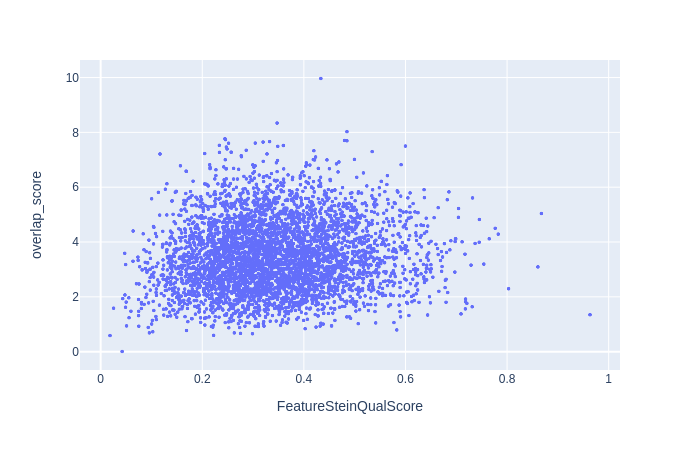

In [121]:
fig = px.scatter(df_chodera, x='FeatureSteinQualScore', y='overlap_score')
fig.update_traces(marker=dict(size=3))
fig.show()

# Frank's designs
These were deisgned with merging to multiple fragments in mind.
They were run through the docking/scoring workflow on Galaxy using free docking.

In [122]:
gz = gzip.open('fra-dia-docked-scored.sdf.gz')
supplr = Chem.ForwardSDMolSupplier(gz)
frank_poses = []
count = 0
for m in supplr:
    frank_poses.append(m)
    count += 1
len(frank_poses)

60

In [123]:
df_frank, frank_x_names, frank_y_names = gen_sucos_scores(frank_poses)

(60, 69)
69
60


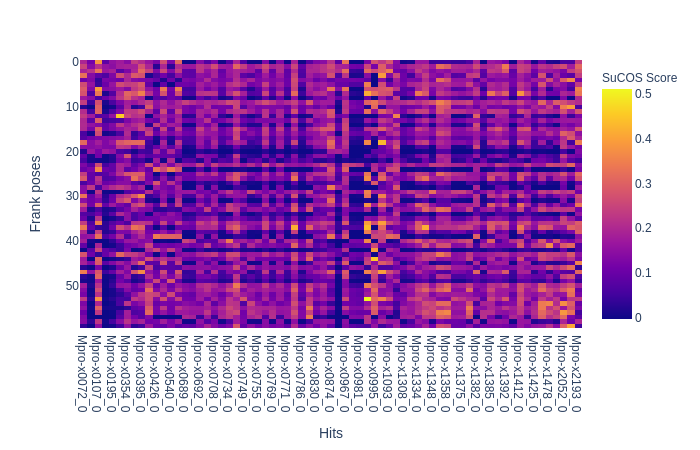

In [124]:
fig = px.imshow(df_frank, labels=dict(x="Hits", y="Frank poses", color="SuCOS Score"), x=frank_x_names)
fig.show()

In [125]:
df_fmapscores_frank = gen_fmap_scores(frank_poses, merged_fmap)
df_fmapscores_frank.shape

(60, 2)

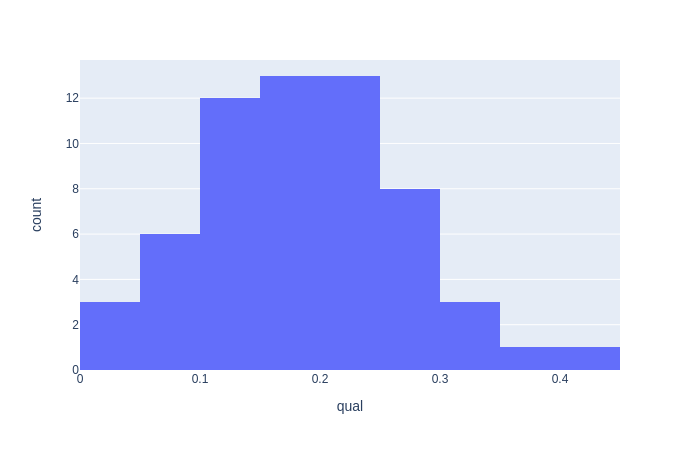

In [126]:
fig = px.histogram(df_fmapscores_frank,  x='qual')
fig.show()

# Non-fragment structures
These are molecules that we have structures for that are not fragment screening hits

In [127]:
gz = gzip.open('non-fragment-mols.sdf.gz')
supplr = Chem.ForwardSDMolSupplier(gz)
extras_poses = []
for m in supplr:
    extras_poses.append(m)
len(extras_poses)

233

In [128]:
df_fmapscores_extras = gen_fmap_scores(extras_poses, merged_fmap)
df_fmapscores_extras.shape

(233, 2)

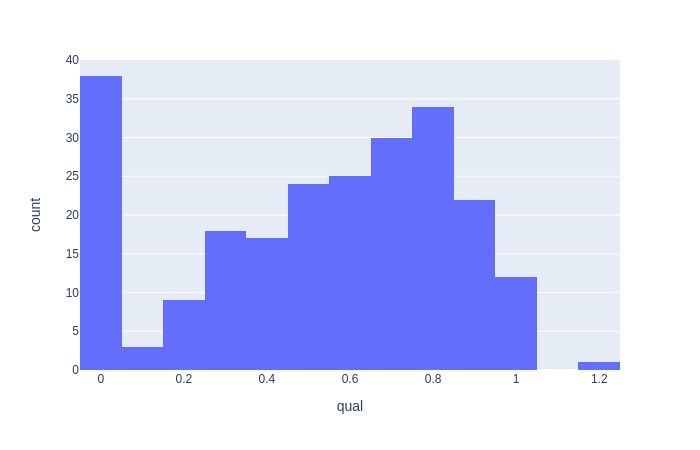

In [129]:
fig = px.histogram(df_fmapscores_extras,  x='qual')
fig.show()

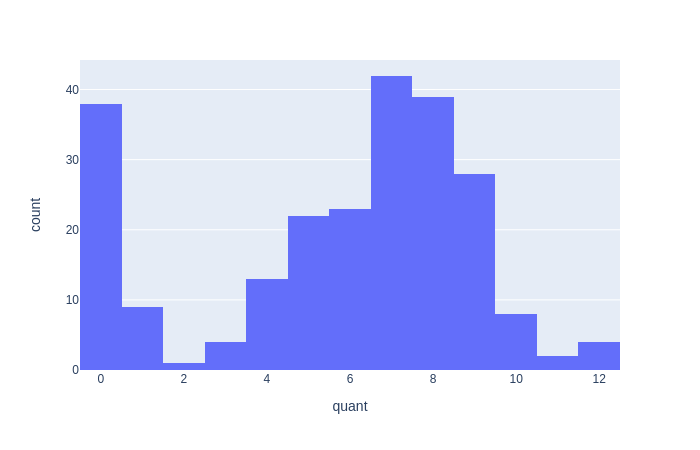

In [130]:
fig = px.histogram(df_fmapscores_extras,  x='quant')
fig.show()

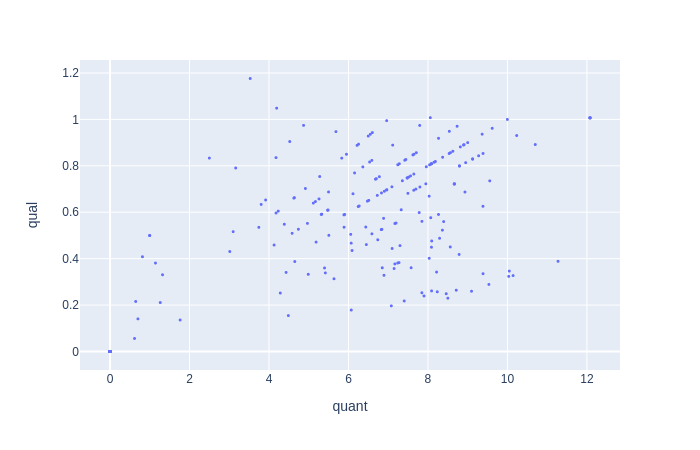

In [142]:
fig = px.scatter(df_fmapscores_extras, x='quant', y='qual')
fig.update_traces(marker=dict(size=3))
fig.show()